In [1]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import statsmodels.stats.multitest as smm
from lsmm_data import LSMMData
import json
from tqdm import tqdm

with open('pyr_chains.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
data_a = my_data.data
params_a = my_data.params
dirs_a = my_data.dirs
mappings_a = my_data.mappings

# with open('pyr_chains_no_a.json') as f:
#     loaded_json = json.load(f)
# my_data_no_a = LSMMData.LSMMData(loaded_json)
# data_no_a = my_data_no_a.data
# params_no_a = my_data_no_a.params
# dirs_no_a = my_data_no_a.dirs
# mappings_no_a = my_data_no_a.mappings
 

# Generate the chain results
# Assembly chain results (no no-a cells exist in their graph)
# Make a graph of just excitatory cells
cell_table = data_a['structural']['pre_cell'].copy()
cell_table['connectome_index'] = cell_table.index
synapse_table = data_a['structural']['synapse']
adjacency_matrix = data_a['structural']['binary_connectome']
pyr_graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)

# Motif Analysis with DotMotif: 2 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
              """)

chain_results = executor.find(chain_defs)
two_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

# Motif Analysis with DotMotif: 3 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C
              """)
chain_results = executor.find(chain_defs)
three_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])

# Motif Analysis with DotMotif: 4 Chain, All Pyr
executor = GrandIsoExecutor(graph=pyr_graph)
chain_defs = Motif("""
                A -> B
                B -> C
                C -> D
              """)
chain_results = executor.find(chain_defs)
four_chain_results_array = np.array([list(c.values()) for c in tqdm(chain_results)])
assembly_chain_results_arrays = [two_chain_results_array, three_chain_results_array, four_chain_results_array]

chain_count_string_array = ['pyr_cell_2chain', 'pyr_cell_3chain', 'pyr_cell_4chain']
individual_assembly_indexes = [mappings_a['connectome_indexes_by_assembly'][f'A {i}'] for i in range(1,14)]

coregistered_cell_indexes = mappings_a['assemblies_by_connectome_index'].keys()
no_a_cell_indexes = mappings_a['connectome_indexes_by_assembly']['No A']
pooled_assembly_indexes = [list(set(coregistered_cell_indexes) - set(no_a_cell_indexes))]

# print('Assembly Root IDs:', list(set(mappings_a['assemblies_by_pt_root_id'].keys()) - set(mappings_a['pt_root_ids_by_assembly']['No A'])))
# print('NonAssembly Root IDs:', mappings_a['pt_root_ids_by_assembly']['No A'])

scaling_factors_two = [len(individual_assembly_indexes[i])-1 for i in range(13)]
scaling_factors_three = [len(individual_assembly_indexes[i])-1 for i in range(13)]
scaling_factors_four = [len(individual_assembly_indexes[i])-1 for i in range(13)]
scaling_factors_lists = [scaling_factors_two, scaling_factors_three, scaling_factors_four]

no_a_scaling_factors_two = len(no_a_cell_indexes)-1
no_a_scaling_factors_three = len(no_a_cell_indexes)-1
no_a_scaling_factors_four = len(no_a_cell_indexes)-1
no_a_scaling_factors = [no_a_scaling_factors_two, no_a_scaling_factors_three, no_a_scaling_factors_four]



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Generating Connectome...


100%|██████████| 4565/4565 [00:00<00:00, 15735.74it/s]


Generating Connectome...


100%|██████████| 309885/309885 [00:00<00:00, 1202685.55it/s]


In [2]:
# # Intra-Assembly to Intra-Assembly chains, assemblies with 5 or more cells
# # with scaling and filtering of no-a cells from assembly chains
# # Individual and pooled results.  Assembly and non-assembly.

multi_length_chain_participation_by_coregistered_cell_pair = {}

for i in range(3):
    chain_results_array = assembly_chain_results_arrays[i]
    title = chain_count_string_array[i]

    # Get chain participation
    chain_participation_by_coregistered_cell_pair = {}
    for index1 in tqdm(coregistered_cell_indexes):
        if index1 not in chain_participation_by_coregistered_cell_pair.keys():
                chain_participation_by_coregistered_cell_pair[index1] = {}
        if index1 not in multi_length_chain_participation_by_coregistered_cell_pair.keys():
                multi_length_chain_participation_by_coregistered_cell_pair[index1] = {}
        for index2 in coregistered_cell_indexes:
            if index2 not in chain_participation_by_coregistered_cell_pair[index1].keys():
                chain_participation_by_coregistered_cell_pair[index1][index2] = 0
            if index2 not in multi_length_chain_participation_by_coregistered_cell_pair[index1].keys():
                multi_length_chain_participation_by_coregistered_cell_pair[index1][index2] = 0
            temp = np.where(np.logical_and(chain_results_array[:,0] == index1, chain_results_array[:,-1] == index2))[0].size
            chain_participation_by_coregistered_cell_pair[index1][index2] += temp
            multi_length_chain_participation_by_coregistered_cell_pair[index1][index2] += temp


# Pool all chain lengths
# Pool cells which are in assemblies
assembly_allchain_pooled_assembly_cell_participation = []
# allchain_pooled_per_item_scaling_factors = []
for chain_length_index in range(3):
    # scaling_factors = scaling_factors_lists[chain_length_index]
    for a_index in [0, 1, 2, 3, 4, 5, 7, 9]:
        scaling_factor = scaling_factors_lists[chain_length_index][a_index]
        if scaling_factor > 0:
            for index in individual_assembly_indexes[a_index]:
                for index2 in individual_assembly_indexes[a_index]:            
                    assembly_allchain_pooled_assembly_cell_participation.append(multi_length_chain_participation_by_coregistered_cell_pair[index1][index2] / scaling_factor)                         


no_a_allchain_pooled_assembly_cell_participation = []
# allchain_pooled_per_item_scaling_factors = []
for chain_length_index in range(3):
    scaling_factor = no_a_scaling_factors[chain_length_index]
    if scaling_factor > 0:
        for index in no_a_cell_indexes:
            for index2 in no_a_cell_indexes:            
                no_a_allchain_pooled_assembly_cell_participation.append(multi_length_chain_participation_by_coregistered_cell_pair[index1][index2] / scaling_factor)                         



100%|██████████| 55/55 [00:01<00:00, 53.57it/s]


Wilcoxon Rank Sum Test: 
	All pyr chain lengths, intra-assembly, normalized by possible chains
	vs All pyr chain lengths, intra-nonassembly, normalized by possible chains
A vs No A
RanksumsResult(statistic=5.122549366281445, pvalue=1.5071607133911634e-07)
A: 
	Mean: 0.12809710865266422
	Median: 0.1
	SD: 0.18657934800631212
No A: 
	Mean: 0.08333333333333333
	Median: 0.09090909090909091
	SD: 0.10135672848681555


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb5ec8766b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb5ec876bf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb5ec876410>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb5ec877130>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb5ec8773d0>,
 'means': []}

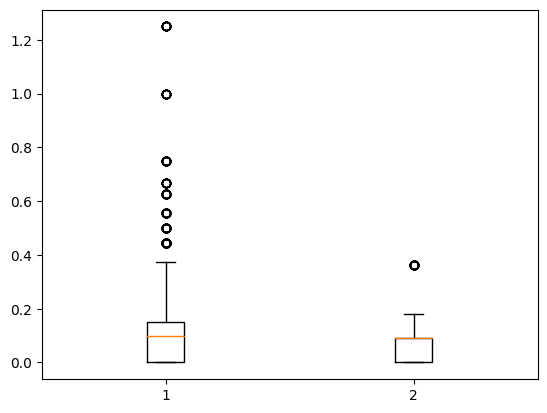

In [5]:
# Now Compare the two
assembly_allchain_pooled_assembly_cell_participation
no_a_allchain_pooled_assembly_cell_participation

import scipy.stats as stats

# Perform Wilcoxon Rank Sum Test
print(f'Wilcoxon Rank Sum Test: \n\tAll pyr chain lengths, intra-assembly, normalized by possible chains\n\tvs All pyr chain lengths, intra-nonassembly, normalized by possible chains')
print('A vs No A')
print(stats.ranksums(assembly_allchain_pooled_assembly_cell_participation, no_a_allchain_pooled_assembly_cell_participation, alternative='greater'))

print(f"A: \n\tMean: {np.mean(assembly_allchain_pooled_assembly_cell_participation)}\n\tMedian: {np.median(assembly_allchain_pooled_assembly_cell_participation)}\n\tSD: {np.std(assembly_allchain_pooled_assembly_cell_participation)}")
print(f"No A: \n\tMean: {np.mean(no_a_allchain_pooled_assembly_cell_participation)}\n\tMedian: {np.median(no_a_allchain_pooled_assembly_cell_participation)}\n\tSD: {np.std(no_a_allchain_pooled_assembly_cell_participation)}")

plt.figure()
plt.box
plt.boxplot([assembly_allchain_pooled_assembly_cell_participation, no_a_allchain_pooled_assembly_cell_participation])
#plt.savefig(f'chains/pyr_all_chain_lengths_intra_pooled.png')
